#### Outlier Detection

In [32]:
import os
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

from IPython.display import display, HTML
#display(HTML(df_perf.to_html()))
%matplotlib inline

os.chdir('/Users/suma/Documents/01 Data Science/Titanic Problem/')

In [3]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

In [5]:
frames = [df_train, df_test]
df = pd.concat(frames, axis = 0, sort = False)

#### Outliers
- Any value, which is beyond the range of -1.5 x IQR to 1.5 x IQR <br>
- Use capping methods. Any value which out of range of 5th and 95th percentile can be considered as outlier <br>
- Data points, three or more standard deviation away from mean are considered outlier <br>
- Outlier detection is merely a special case of the examination of data for influential data points  and it also depends on the business understanding <br>
- Bivariate and multivariate outliers are typically measured using either an index of influence or leverage, or distance. Popular indices such as Mahalanobis’ distance and Cook’s D are frequently used to detect outliers. <br>

<img src='Outlier-image.png'>

##### Statistics for Outlier Detection

In [36]:
numeric_variables = ['Age', 'Fare']

for col in numeric_variables:
    mask = df[col].notnull()
    print(col, ":")
    print("\tmean:", df[col].mean())
    print("\tmedian:", df[col].median())
    print("\tmode:", df[col].mode())    
    print("\tstddev:", df[col].std())
    IQR = round(iqr(df[mask][col], rng=(25,75), interpolation='midpoint'),2)
    print("\t IQR:", IQR)
    print("\t -1.5IQR - 1.5IQR:",-1.5*IQR, ' - ', 1.5*IQR)

Age :
	mean: 29.881137667304014
	median: 28.0
	mode: 0    24.0
dtype: float64
	stddev: 14.413493211271334
	 IQR: 18.0
	 -1.5IQR - 1.5IQR: -27.0  -  27.0
	 95th percentile: 57.0
Fare :
	mean: 33.2954792813456
	median: 14.4542
	mode: 0    8.05
dtype: float64
	stddev: 51.75866823917414
	 IQR: 23.38
	 -1.5IQR - 1.5IQR: -35.07  -  35.07
	 95th percentile: 133.65


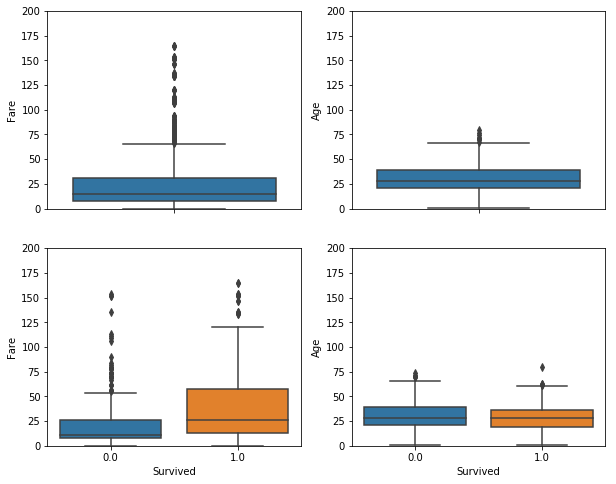

In [38]:
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.ylim(0,200)
sns.boxplot(y="Fare", data=df);
plt.subplot(2,2,2)
plt.ylim(0,200)
sns.boxplot(y="Age", data=df);
plt.subplot(2,2,3)
plt.ylim(0,200)
sns.boxplot(x= 'Survived', y="Fare", data=df);
plt.subplot(2,2,4)
plt.ylim(0,200)
sns.boxplot(x= 'Survived', y="Age", data=df);

#### Artificial outliers like data errors should be imputed by mean

In [74]:
#### Imputing outliers (values outside 1.5IQR by their mean)
outlier_columns = ['Fare', 'Age']
for col in outlier_columns:
    mask1 = df[col].notnull()
    IQR = round(iqr(df[mask][col], rng=(25,75)),2)
    mask2 = np.logical_or(df[col] > 1.5*IQR, df[col] < -1.5* IQR)
    df.loc[mask2, col] = df[col].mean()

#### Multivariate outlier identification using mahalanobis distance measure

Euclidean Metric fails to find the correct distance because it tries to get ordinary straight-line distance. So if we have multi-dimension space of variables, two points may look to have same distance from the Mean but in reality one of them is far away from the data cloud (i.e. it's extreme value).

<img src = "Mahala-image1.png">
The solution is Mahalanobis Distance which makes something similar to the feature scaling via taking the Eigenvectors of the variables instead of the original axis.

It applies the following formula:<br>
<img src = "Mahala-image2.png">

xbar is the observation to find its distance <br>
mu is the mean of the observations <br>
S is the Covariance Matrix <br>

Things to note:<br>
- Practically speaking, if you have a lot of features and lesser examples (i.e inputs), Mahalanobis algorithm tends to give misleading results (you can try it yourself), so the more features you have, the more examples you should provide. <br>
- The covariance matrix must be Symmetric and Positive Definite to make the algorithm works, so you should check before proceeding!

In [ ]:
def create_data(examples=50, features=5, upper_bound=10, outliers_fraction=0.1, extreme=False):
    '''
    This method for testing (i.e. to generate a 2D array of data)
    '''
    data = []
    magnitude = 4 if extreme else 3
    for i in range(examples):
        if (examples - i) <= round((float(examples) * outliers_fraction)):
            data.append(np.random.poisson(upper_bound ** magnitude, features).tolist())
        else:
            data.append(np.random.poisson(upper_bound, features).tolist())
    return np.array(data)

In [ ]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [ ]:
def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    #one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
        outliers.append(i)  # index of the outlier
    return np.array(outliers)

#### Decision Tree to bin Fare/Age column inorder to handle outliers

#### Outlier Detection using PyOD Library

In [81]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers

Text(0, 0.5, 'F2')

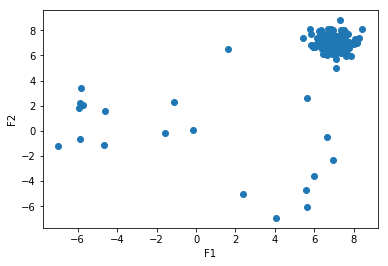

In [89]:
# by default the outlier fraction is 0.1 in generate data function ; outlier_fraction = 0.1

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

In [79]:
pyod.utils.data.generate_data?

Object `pyod.utils.data.generate_data` not found.


In [90]:
n_inliers

180

In [92]:
range(df.shape[0])

range(0, 1309)